In [1]:
# Core imports
import numpy as np
import heyoka as hk
import pykep as pk

# Sys imports
import time

# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

# 1 - Defining all the problem constants in the SI units (lengths in km)

In [2]:
#constants
GMe = 3.986004407799724e+5 # [km^3/sec^2]
GMo = 1.32712440018e+11 #[km^3/sec^2]
GMm = 4.9028e+3 #[km^3/sec^2]
Re = 6378.1363 #[km]
C20 = -4.84165371736e-4
C22 = 2.43914352398e-6
S22 = -1.40016683654e-6
theta_g = (np.pi/180)*280.4606 #[rad]
nu_e = (np.pi/180)*(4.178074622024230e-3) #[rad/sec]
nu_o = (np.pi/180)*(1.1407410259335311e-5) #[rad/sec]
nu_ma = (np.pi/180)*(1.512151961904581e-4) #[rad/sec]
nu_mp = (np.pi/180)*(1.2893925235125941e-6) #[rad/sec]
nu_ms = (np.pi/180)*(6.128913003523574e-7) #[rad/sec]
alpha_o = 1.49619e+8 #[km]
epsilon = (np.pi/180)*23.4392911 #[rad]
phi_o = (np.pi/180)*357.5256 #[rad]
Omega_plus_w = (np.pi/180)*282.94 #[rad]
PSRP = 4.56e-3 #[kg/(km*sec^2)]

# 2 - Preparing the equations of motion.

In [3]:
#create heyoka variables
X,Y,Z = hk.make_vars("X","Y","Z")
VX,VY,VZ = hk.make_vars("VX","VY","VZ")

In [4]:
############################# RHS (right hand side of the ODE) setup #############################

#Sun's position
lo = phi_o + nu_o*hk.time
lambda_o = Omega_plus_w + lo + (np.pi/180)*( (6892/3600)*hk.sin(lo) + (72/3600)*hk.sin(2*lo) )
ro = (149.619 - 2.499*hk.cos(lo) - 0.021*hk.cos(2*lo))*(10**6)

Xo = ro*hk.cos(lambda_o)
Yo = ro*hk.sin(lambda_o)*np.cos(epsilon)
Zo = ro*hk.sin(lambda_o)*np.sin(epsilon)

#Moon's position
phi_m = nu_o*hk.time
phi_ma = nu_ma*hk.time
phi_mp = nu_mp*hk.time
phi_ms = nu_ms*hk.time
L0 = phi_mp + phi_ma + (np.pi/180)*218.31617
lm = phi_ma + (np.pi/180)*134.96292
llm = phi_m + (np.pi/180)*357.5256
Fm = phi_mp + phi_ma + phi_ms + (np.pi/180)*93.27283
Dm = phi_mp + phi_ma - phi_m  + (np.pi/180)*297.85027

rm = 385000 - 20905*hk.cos(lm) - 3699*hk.cos(2*Dm - lm) - 2956*hk.cos(2*Dm) - \
     570*hk.cos(2*lm) + 246*hk.cos(2*lm - 2*Dm) - 205*hk.cos(llm - 2*Dm) - \
     171*hk.cos(lm + 2*Dm) - 152*hk.cos(lm + llm - 2*Dm)
     
lambda_m = L0 + (np.pi/180)*( (22640/3600)*hk.sin(lm) + (769/3600)*hk.sin(2*lm) - (4856/3600)*hk.sin(lm - 2*Dm) + \
     (2370/3600)*hk.sin(2*Dm) - (668/3600)*hk.sin(llm) - (412/3600)*hk.sin(2*Fm) - \
     (212/3600)*hk.sin(2*lm - 2*Dm) - (206/3600)*hk.sin(lm + llm - 2*Dm) + \
     (192/3600)*hk.sin(lm + 2*Dm) - (165/3600)*hk.sin(llm - 2*Dm) + \
     (148/3600)*hk.sin(lm - llm) - (125/3600)*hk.sin(Dm) - (110/3600)*hk.sin(lm + llm) - \
     (55/3600)*hk.sin(2*Fm - 2*Dm) )
     
βm = (np.pi/180)*( (18520/3600)*hk.sin(Fm + lambda_m - L0 + (np.pi/180)*((412/3600)*hk.sin(2*Fm) + (541/3600)*hk.sin(llm)) ) - \
     (526/3600)*hk.sin(Fm - 2*Dm) + (44/3600)*hk.sin(lm + Fm - 2*Dm) - (31/3600)*hk.sin(-lm + Fm -2*Dm) - \
     (25/3600)*hk.sin(-2*lm + Fm) - (23/3600)*hk.sin(llm + Fm - 2*Dm) + (21/3600)*hk.sin(-lm + Fm) + \
     (11/3600)*hk.sin(-llm + Fm - 2*Dm) )
     
Xm =  hk.cos(βm)*hk.cos(lambda_m)*rm
Ym = -np.sin(epsilon)*hk.sin(βm)*rm + np.cos(epsilon)*hk.cos(βm)*hk.sin(lambda_m)*rm
Zm =  np.cos(epsilon)*hk.sin(βm)*rm + hk.cos(βm)*np.sin(epsilon)*hk.sin(lambda_m)*rm

#Earth's Keplerian terms
magR2 = X**2 + Y**2 + Z**2
fKepX = -GMe*X/(magR2**(3./2))
fKepY = -GMe*Y/(magR2**(3./2))
fKepZ = -GMe*Z/(magR2**(3./2))

#Earth's J2 terms
J2term1 = GMe*(Re**2)*np.sqrt(5)*C20/(2*magR2**(1./2))
J2term2 = 3/(magR2**2)
J2term3 = 15*(Z**2)/(magR2**3)
fJ2X = J2term1*X*(J2term2 - J2term3)
fJ2Y = J2term1*Y*(J2term2 - J2term3)
fJ2Z = J2term1*Z*(3*J2term2 - J2term3)

#Earth's C22 and S22 terms
x =  X*hk.cos(theta_g + nu_e*hk.time) + Y*hk.sin(theta_g + nu_e*hk.time)
y = -X*hk.sin(theta_g + nu_e*hk.time) + Y*hk.cos(theta_g + nu_e*hk.time)
z = Z
magr2 = x**2 + y**2 + z**2

C22term1 = 5*GMe*(Re**2)*np.sqrt(15)*C22/(2*magr2**(7./2))
C22term2 = GMe*(Re**2)*np.sqrt(15)*C22/(magr2**(5./2))
fC22x = C22term1*x*(y**2 - x**2) + C22term2*x
fC22y = C22term1*y*(y**2 - x**2) - C22term2*y
fC22z = C22term1*z*(y**2 - x**2)

S22term1 = 5*GMe*(Re**2)*np.sqrt(15)*S22/(magr2**(7./2))
S22term2 = GMe*(Re**2)*np.sqrt(15)*S22/(magr2**(5./2))
fS22x = -S22term1*(x**2)*y + S22term2*y
fS22y = -S22term1*x*(y**2) + S22term2*x
fS22z = -S22term1*x*y*z

fC22X = fC22x*hk.cos(theta_g + nu_e*hk.time) - fC22y*hk.sin(theta_g + nu_e*hk.time)
fC22Y = fC22x*hk.sin(theta_g + nu_e*hk.time) + fC22y*hk.cos(theta_g + nu_e*hk.time)
fC22Z = fC22z

fS22X = fS22x*hk.cos(theta_g + nu_e*hk.time) - fS22y*hk.sin(theta_g + nu_e*hk.time)
fS22Y = fS22x*hk.sin(theta_g + nu_e*hk.time) + fS22y*hk.cos(theta_g + nu_e*hk.time)
fS22Z = fS22z

#Sun's gravity
magRo2 = Xo**2 + Yo**2 + Zo**2
magRRo2 = (X - Xo)**2 + (Y - Yo)**2 + (Z - Zo)**2
fSunX = -GMo*( (X - Xo)/(magRRo2**(3./2)) + Xo/(magRo2**(3./2)) )
fSunY = -GMo*( (Y - Yo)/(magRRo2**(3./2)) + Yo/(magRo2**(3./2)) )
fSunZ = -GMo*( (Z - Zo)/(magRRo2**(3./2)) + Zo/(magRo2**(3./2)) )

#Moon's gravity 
magRm2 = Xm**2 + Ym**2 + Zm**2
magRRm2 = (X - Xm)**2 + (Y - Ym)**2 + (Z - Zm)**2
fMoonX = -GMm*( (X - Xm)/(magRRm2**(3./2)) + Xm/(magRm2**(3./2)) )
fMoonY = -GMm*( (Y - Ym)/(magRRm2**(3./2)) + Ym/(magRm2**(3./2)) )
fMoonZ = -GMm*( (Z - Zm)/(magRRm2**(3./2)) + Zm/(magRm2**(3./2)) )

#Sun's radiation pressure (AOM is a heyoka parameter hy.par[0]. We
#will be able to set it later without recompiling the integartor)
SRPterm = hk.par[0]*PSRP*(alpha_o**2)/(magRRo2**(3./2))
fSRPX = SRPterm*(X - Xo)
fSRPY = SRPterm*(Y - Yo)
fSRPZ = SRPterm*(Z - Zo)

############################# end of RHS setup #############################

# 3 - EOM

In [5]:
dXdt = VX
dYdt = VY
dZdt = VZ
dVXdt = fKepX + fJ2X + fC22X + fS22X + fSunX + fMoonX + fSRPX
dVYdt = fKepY + fJ2Y + fC22Y + fS22Y + fSunY + fMoonY + fSRPY
dVZdt = fKepZ + fJ2Z + fC22Z + fS22Z + fSunZ + fMoonZ + fSRPZ

# 4 - Instantiate the Heyoka (Taylor) integrator

In [6]:
# Initial conditions (ic) -  can be changed later
x0  = -8509.601467747452261 #[km]
y0  = 41462.967598908115178 #[km]
z0  = 4433.499739334900369 #[km]
vx0 = -2.976021793775544 #[km/sec]
vy0 = -0.623108664781654 #[km/sec]
vz0 = 0.235057994478775 #[km/sec]

t0 = 0.0 #[in seconds past the epoch 0]

ic = [x0,y0,z0,vx0,vy0,vz0]

print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(X,dXdt),(Y,dYdt),(Z,dZdt),(VX,dVXdt),(VY,dVYdt),(VZ,dVZdt)],
                        state = ic,
                        time = t0,
                        tol = 1e-16,
                        compact_mode = True)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 1.855943202972412 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 6
Time                    : 0.0000000000000000
State                   : [-8509.6014677474523, 41462.967598908115, 4433.4997393349004, -2.9760217937755442, -0.62310866478165405, 0.23505799447877501]
Parameters              : [0.0000000000000000]



# 5 - Defining an initial value problem

In [7]:
# How many years to integrate
years = 5
tmax = years*365.25*24*60*60 #[sec]

# How often to log the state
dt = 24*60*60/60 #[sec]

# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] = [x0,y0,z0,vx0,vy0,vz0]

# And we set the parameters of the integrator (in this case the AOM)
AOM = 15.48302e-6 #[km^2/kg]
ta.pars[0] = AOM

# 6 - Performing the numerical propagation

In [8]:
print('Numerically propagating the orbit for {} years'.format(years))

tgrid = np.linspace(t0, tmax ,int(1 + tmax/dt), endpoint = True)

start_time = time.time()
out = ta.propagate_grid(tgrid)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
sol = out[4] 

Numerically propagating the orbit for 5 years
Done, in
--- 1.201003074645996 seconds ---


# 7 - Plots

<IPython.core.display.Javascript object>


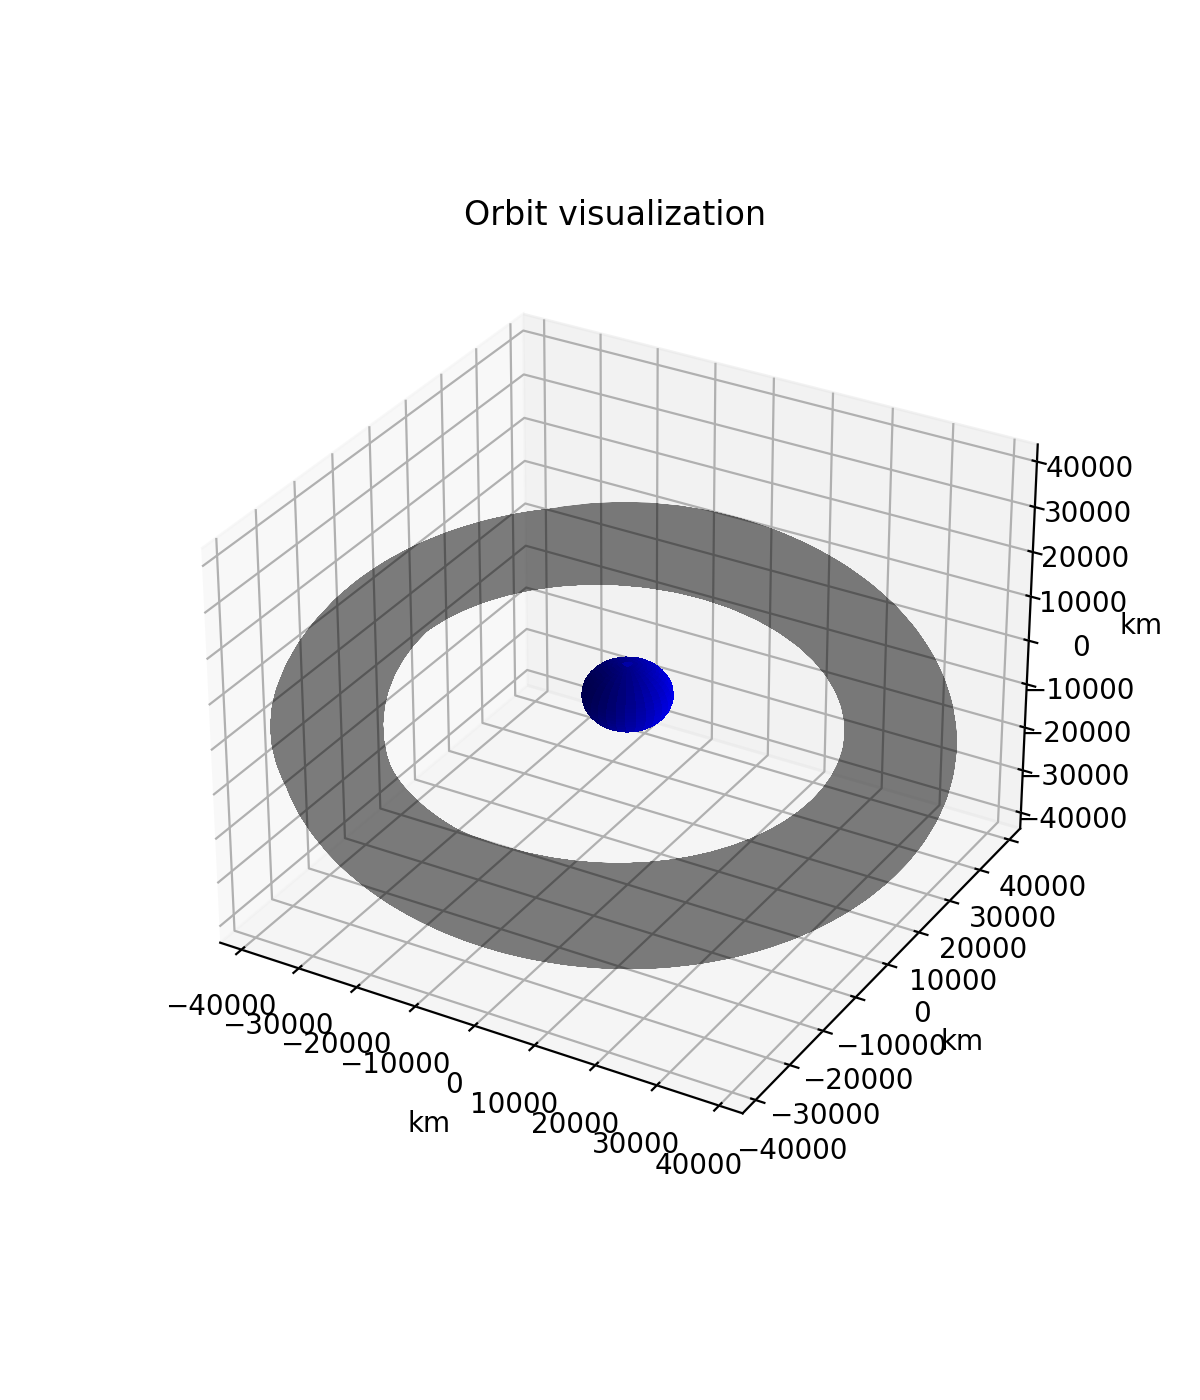

Text(0.5, 0, 'km')

In [9]:
fig = plt.figure(figsize = (6,7))
ax = plt.axes(projection='3d')

# We plot the orbit
ax.plot(sol[:,0],sol[:,1],sol[:,2], 'k', alpha=0.5)

# We plot the Earth
theta, phi = np.linspace(0, 2 * np.pi, 30), np.linspace(0, np.pi, 30)
THETA, PHI = np.meshgrid(theta, phi)
R = 6700.
X_sphere = R * np.sin(PHI) * np.cos(THETA)
Y_sphere = R * np.sin(PHI) * np.sin(THETA)
Z_sphere = R * np.cos(PHI)
ax.plot_surface(X_sphere, Y_sphere, Z_sphere, rstride=1, cstride=1, linewidth=0, color='blue', antialiased=False, alpha=1)

# We set the axis
ax.set_xlim([-42000, 42000])
ax.set_ylim([-42000, 42000])
ax.set_zlim([-42000, 42000])

# We put title and labels
plt.title("Orbit visualization")
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_zlabel('km')


# 8 - Converting to Keplerian elements

In [10]:
size = np.shape(sol)
# Convert to Keplerian Elements
sol_el = np.zeros(size)
for i, cartesian in enumerate(sol):
    sol_el[i] = pk.ic2par(cartesian[:3], cartesian[3:], GMe)

<IPython.core.display.Javascript object>


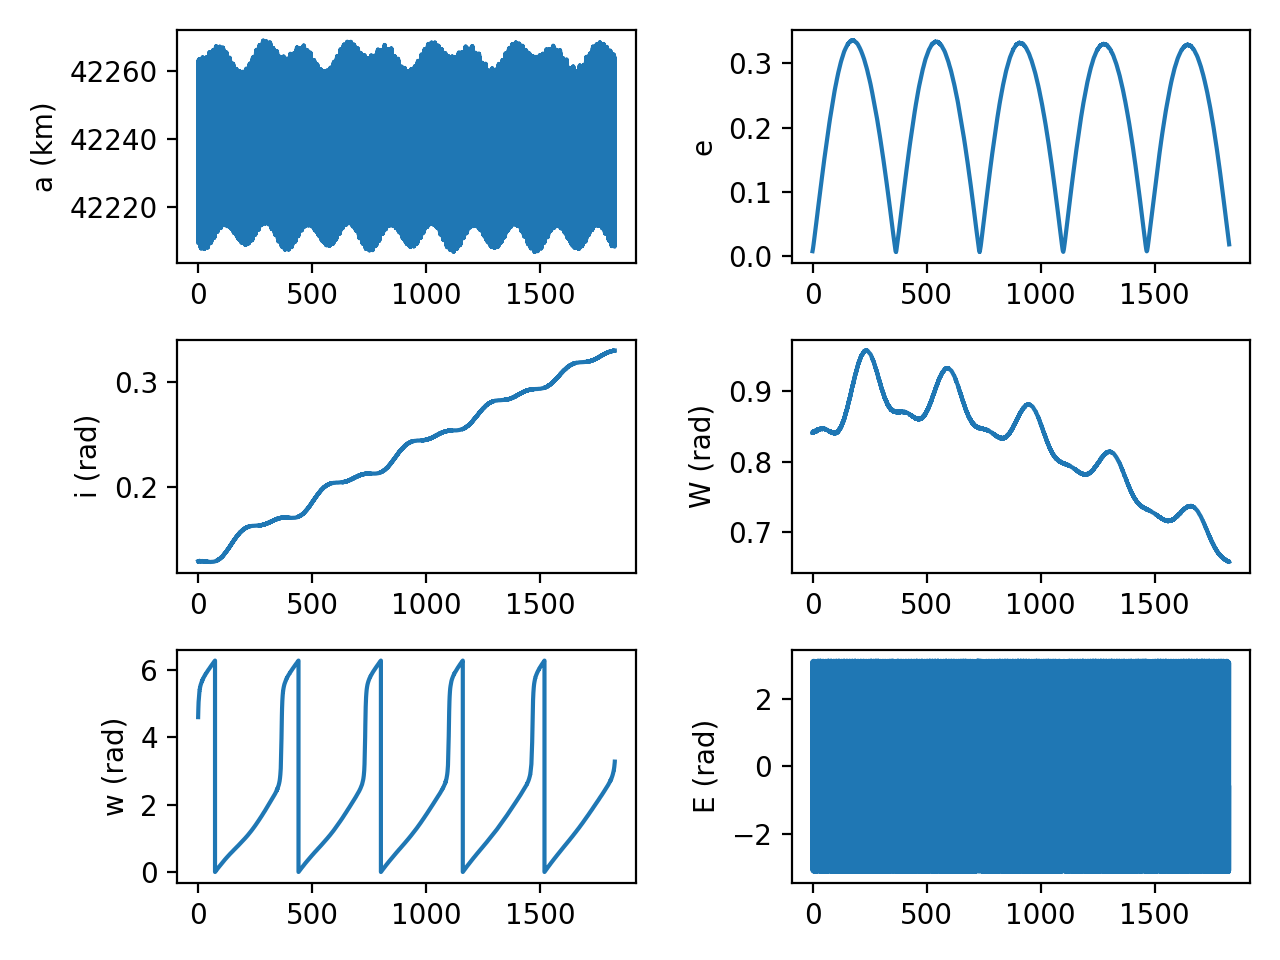

In [11]:
fig, axs = plt.subplots(3, 2)
axs = axs.reshape(6,)
for i in range(6):
    axs[i].plot(tgrid * pk.SEC2DAY, sol_el[:,i])
axs[0].set_ylabel("a (km)")
axs[1].set_ylabel("e")
axs[2].set_ylabel("i (rad)")
axs[3].set_ylabel("W (rad)")
axs[4].set_ylabel("w (rad)")
axs[5].set_ylabel("E (rad)")

plt.tight_layout()

# 9 - Sensitivity Analysis on Cr(A/M)

In [12]:
# Let us reset here the inictial conditions
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] = [x0,y0,z0,vx0,vy0,vz0]

# And change the AOM coefficient (effective area over mass ratio) by 10%
AOM_2 = 15.48302e-6 + 1e-1 * AOM #[km^2/kg]
ta.pars[0] = AOM_2

In [13]:
print('Numerically propagating the orbit for {} years'.format(years))

tgrid = np.linspace(t0, tmax ,int(1 + tmax/dt), endpoint = True)

start_time = time.time()
out = ta.propagate_grid(tgrid)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
sol2 = out[4] 

Numerically propagating the orbit for 5 years
Done, in
--- 1.1807851791381836 seconds ---


In [14]:
size = np.shape(sol2)
# Convert to Keplerian Elements
sol2_el = np.zeros(size)
for i, cartesian in enumerate(sol2):
    sol2_el[i] = pk.ic2par(cartesian[:3], cartesian[3:], GMe)

<IPython.core.display.Javascript object>


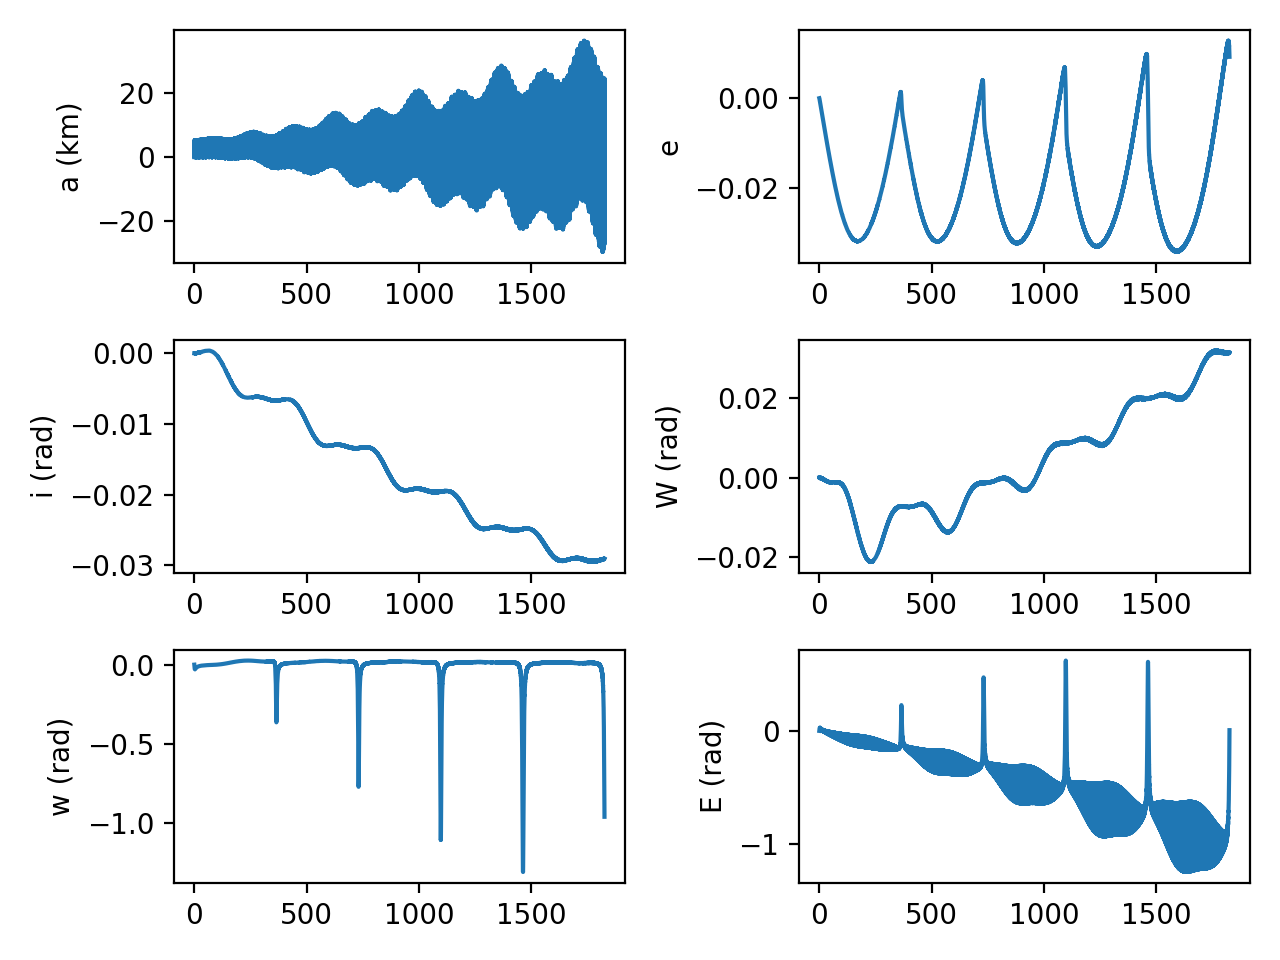

In [15]:
def normalize_diff(radians):
    mask  = radians < -180 * pk.DEG2RAD
    radians[mask] = radians[mask] + 360* pk.DEG2RAD
    mask  = radians > 180 * pk.DEG2RAD
    radians[mask] = radians[mask] - 360* pk.DEG2RAD

fig, axs = plt.subplots(3, 2)
axs = axs.reshape(6,)

diff = sol_el-sol2_el

normalize_diff(diff[:,-1])
normalize_diff(diff[:,-2])
normalize_diff(diff[:,-3])
normalize_diff(diff[:,-4])


for i in range(6):
    axs[i].plot(tgrid * pk.SEC2DAY, diff[:,i])
axs[0].set_ylabel("a (km)")
axs[1].set_ylabel("e")
axs[2].set_ylabel("i (rad)")
axs[3].set_ylabel("W (rad)")
axs[4].set_ylabel("w (rad)")
axs[5].set_ylabel("E (rad)")

plt.tight_layout()

